# Hypothesis Testing and the Likelihood Principle

This notebook exlores a problem with classical statistical hypothesis testing, and an important principle of statistical inference, using an example of determining the bias of a bent coin.

This is mostly an expository text, but with some code to illustrate the point, which the reader can modify to explore further.

## A Problematic Hypothesis Test

*This section sets the scene by introducing an inference problem, performing classical hypothesis tests, and showing the surprising fact that the results of a hypothesis test can depend on seemingly unimportant assumptions about the intentions of people conducting an experiment, as well as on the actual results of the experiment!*

*There is a mixture of exposition and code the reader can play with.*

Suppose I have a bent coin; it lands heads up with some unknown probability $p$, which may still be 0.5 (the bend might not have an affect), or might be different from 0.5

An experimenter tosses the coin a large number of times to try to find the value of $p$. You and I observe the experimenter make $N$ tosses, of which $n_H$ are heads. You and I then, each separately, carry out a hypothesis test at the 5% significance level to test the null hypothesis that the coin is unbiased (i.e., that $p=0.5$). For simplicity, let's assume $n_H<\frac{N}{2}$, so it seems that $p\leq 0.5$; we therefore carry out one-tailed hypothesis tests.

You carry out your hypothesis test by assuming that the experimenter had picked the number $N$ of tosses in advance, and so you use a binomial distribution to model the tosses; the parameters of the binomial model are $N$ trials and probability 0.5 of success on each trial (under the null hypothesis). For your one-tailed test, you calculate the probability of seeing $n_H$ or fewer heads in this binomial model, and compare this probability to the significance level.

However, I assume the experimenter instead fixed $n_H$, the number of heads, in advance, and kept tossing the coin until they obtained that number of heads, then counted up the number of tails they got before managing that number of heads, which is $N-n_H$. My hypothesis test uses a negative binomial distribution, which models the number of failures before a specified number of successes is reached in repeated tosses. The parameters of my negative binomial model are the number of successes $n_H$ and the probability of success on each trial, $p=0.5$ under the null hypothesis. I calculate the probability of having $N-n_H$ or more failures before seeing $n_H$ successes, and compare this to the significance level.

We are both testing the same null hypothesis, at the same significance level, with seemingly only superficial differences in how we are modelling the situation. Indeed, the only difference in our models is in what we imagined the experimenter's plan to be; as this is only a matter of their mindset, not anything to do with the actual data we have observed, this difference should not have an effect on our conclusions. We shall show that in fact it can!

In [1]:
# useful imports

import numpy as np
import scipy.stats as stats
from scipy.integrate import quad as integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# use a binomial model to test whether the probability of a head is lower than would be expected
# under the null hypothesis null_prob_head

def binom_hypothesis_tester(significance_level, number_tosses, null_prob_head, number_heads):
    return stats.binom.cdf(number_heads, n=number_tosses, p=null_prob_head) < significance_level

In [3]:
# use a negative binomial model to test whether the probability of a head is lower than would be expected
# under the null hypothesis null_prob_head

def neg_binom_hypothesis_tester(significance_level, number_tosses, null_prob_head, number_heads):
    return (1 - stats.nbinom.cdf(number_tosses - number_heads, n=number_heads, p=null_prob_head)) < significance_level

In [4]:
# search for "natural seeming" values of number_tosses and number_heads (multiples of 10)
# such that the binomial and negative-binomial models give different conclusions at a specified significance
# level and with a specified null hypothesis

significance_level = 0.05
null_prob_head = 0.5

for number_tosses in range(10, 1001, 10):
    for number_heads in range(10, int(number_tosses/2), 10):
        if (binom_hypothesis_tester(significance_level,
                                       number_tosses,
                                       null_prob_head,
                                       number_heads
                                      )
            != neg_binom_hypothesis_tester(significance_level,
                                           number_tosses,
                                           null_prob_head,
                                           number_heads
                                          ) # if one of the models, but not both, gives a significant result
           ):
            # print the values which lead to the two models giving different results
            print("tosses: %d, heads: %d" % (number_tosses, number_heads))

tosses: 140, heads: 60
tosses: 160, heads: 70
tosses: 330, heads: 150
tosses: 350, heads: 160
tosses: 580, heads: 270
tosses: 600, heads: 280
tosses: 620, heads: 290
tosses: 890, heads: 420
tosses: 910, heads: 430
tosses: 930, heads: 440
tosses: 950, heads: 450


In [5]:
# taking number_tosses=950, number_heads=450 from the above

number_tosses = 950
number_heads = 450

binom = stats.binom(n=number_tosses, p=0.5)
neg_binom = stats.nbinom(n=number_heads, p=0.5)

In [6]:
# probability of getting number_heads or fewer heads in number_tosses tosses

binom.cdf(number_heads)

0.05591932257076377

So under the binomial model, tossing 450 heads out of 950 tosses is not significant at the 5% level; we do not reject the null hypothesis, and continue to believe the coin is fair

In [7]:
# probability of needing at least number_tosses tosses to get number_heads heads

1 - neg_binom.cdf(number_tosses - number_heads)

0.048971292732894245

So under the negative binomial model, taking 950 tosses to get 450 heads is significant at the 5% level; we reject the null hypothesis and now believe the coin to be biased towards tails

### So our inference - whether or not we reject the null hypothesis - depends on our beliefs about the intentions of the experimenter, not just the actual data!

Moreover, this is not a particularly uncommon phenomenon. We can see from the number of pairs of values (tosses, heads) we found that, even restricting to multiples of 10, so as to seem chosen by a human, there are several values where this difference in conclusion will occur. Removing the restriction to multiples of 10 gives a much larger range of problematic values.

Also, we were able to find examples with a very large number of tosses; generally, we would expect a statistical test to be more reliable the larger the sample, but no matter how large a sample we pick, we cannot escape the possibility of our inference depending on our beliefs about the experimenter's mindset, not just the actual data.

## The Likelihood Principle

*This expository section introduces some theory and a key principle of inference, and demonstrates that the hypothesis tests of the above example violate this principle.*

Given a statistical model with a parameter $p$, and some data $x$, the **likelihood** of $p$ given $x$ is the function
$$l(p|x) = P(x|p).$$

This may seem strange; we are taking the probability of the data $x$ given the parameter $p$ and simply giving it a new name. The key difference is that in the conditional probability $P(x|p)$, we regard $p$ as having a fixed value and $x$ as being variable, whereas in the likelihood function $l(p|x)$, we take the opposite view: that the data $x$ are fixed and $p$ is variable.

An important consequence of this is that $l(p|x)$ is **not** a probability function; in particular, its integral over its support can be greater than 1.

The **likelihood principle** is a guiding principle of statistical inference, which says that when making an inference about an unknown parameter $p$ on the basis of some data $x$, the only thing which should matter is the likelihood function $l(p|x)$, and then only up to scaling by a non-zero constant. So if $x$ and $y$ are two different data, and there is a constant $\alpha\neq 0$ such that $l(p|x)=\alpha l(p|y)$, then $x$ and $y$ should be regarded as indistinguishable for the purposes of inference. We will justify this more in the next section.

This principle now allows us to explore the problem with the hypothesis testing example above. The simple reason for the problem is that **hypothesis testing does not obey the likelihood principle.**

In the situation above, the unknown parameter $p$ is the probability of getting a head when tossing the coin. The data $x$ we observe are $N$ tosses, of which $n_H$ are heads. The likelihood of $p$ given these data is $l(p|x)=P(x|p)$; but to calculate this we need to choose the generating model for the data $x$.

If we choose a binomial model, we need the probability that in $N$ tosses we will obtain exactly $n_H$ heads, which is
$${N\choose n_H} p^{n_H}(1-p)^{N-n_H}=\frac{N!}{(N-n_H)!n_H!}p^{n_H}(1-p)^{N-n_H}.$$

If, on the other hand, we choose a negative binomial model, we need the probability of it taking exactly $N$ tosses to obtain $n_H$ heads, which is
$${N-1\choose n_H-1} p^{n_H}(1-p)^{N-n_H}=\frac{(N-1)!}{(N-n_H)!(n_H-1)!}p^{n_H}(1-p)^{N-n_H}.$$

The difference between these two expressions (the probability mass functions of the binomial and negative binomial distributions) comes because in the binomial model, the $n_H$ heads can occur anywhere among the $N$ tosses, whereas in the negative binomial model, the $N^\mathrm{th}$ toss must be one of the $n_H$ heads - otherwise we would have stopped tossing sooner. Having the same number of heads and tails means both functions have the same dependence on $p$, but the constant coefficient in front is different, reflecting the differences in how the two models constrain the order of the tosses.

Note, however, that these two expressions differ only by a constant factor. If we let $x$ denote the binomial model of the data and $y$ denote the negative binomial model, then we have
$$l(p|x)=\frac{N}{n_H}l(p|y).$$

Therefore, by the likelihood principle, any inference should be blind to the difference between the data $x$ and $y$. But hypothesis testing, as we saw above, is not, and the conclusion of a hypothesis test can depend on whether we use a binomial or a negative binomial model; so hypothesis testing violates the likelihood principle, as claimed!

## A Bayesian Approach

*This section explores an alternative approach to inference, provides further justification for the likelihood principle, and argues that bayesian inference is superior to frequentist methods such as hypothesis testing.*

*A mixture of exposition and code.*

We have some data $x$, and want to make an inference about the value of a parameter $p$. What we want is, for different possible values of $p$, to know the probability that $p$ takes that value, given the data; in other words, we want to know the posterior probability $P(p|x)$. By Bayes' Theorem:
$$ P(p|x)= \frac{P(x|p)P(p)}{P(x)},$$
or
$$\mathrm{posterior} = \frac{\mathrm{likelihood} \times \mathrm{prior}}{\mathrm{evidence}}.$$

To find the probability of the evidence, $P(x)$, we can integrate over all possible values of $p$:
$$P(x)=\int P(x|q)P(q)\;\mathrm{d}q,$$
where $q$ is a dummy variable of integration.

So if we know $P(x|p)$ and $P(p)$ for each different value of $p$, then we can find the value of $P(p|x)$. But $P(x|p)$ as $p$ varies is precisely the likelihood function $l(p|x)$; so for bayesian inference, we need only know the likelihood of $p$ given our evidence, and the prior distribution of $p$.

Moreover, if  $y$ is an alternative piece of evidence, with $l(p|y)=\alpha l(p|x)$ for some non-zero constant $\alpha$, then the above integral gives $P(y)=\alpha P(x)$, so we have
$$\begin{align*} P(p|y) &= \frac{l(p|y)P(p)}{P(y)}\\ &= \frac{\alpha l(p|x)P(p)}{\alpha P(x)}\\ &= \frac{l(p|x)P(p)}{P(x)}\\ &= P(p|x), \end{align*}$$
so **bayesian inference obeys the likelihood principle.** In particular, a bayesian approach won't care whether we model the coin tosses as binomial or negative binomial, and so will not be subject to the same problem as hypothesis testing.

In [8]:
# consider the situation we had before, where with 950 tosses, of which 450 were heads, hypothesis testing gave
# different conclusions depending on the model used to describe the experiment

number_tosses = 950
number_heads = 450

In [9]:
# define the likelihood function for the binomial model

def binom_likelihood(p):
    return stats.binom.pmf(number_heads, p=p, n=number_tosses)

In [10]:
# define the likelihood function for the negative binomial model
# by what we showed above, this is simply N/n_h times the binomial likelihood, but we will illustrate this

def neg_binom_likelihood(p):
    return stats.nbinom.pmf(number_tosses - number_heads, p=p, n=number_heads)

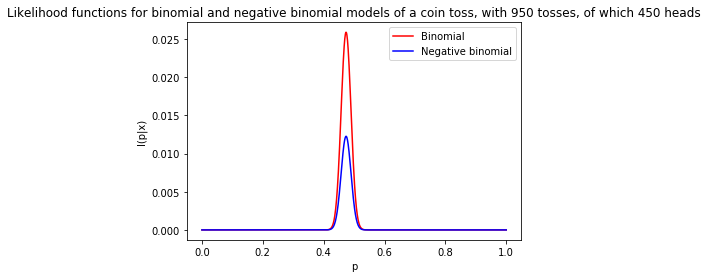

In [11]:
# visualise the likelihood functions

p_array = np.linspace(0.000001, 1, 1000) # p can take values between 0 and 1; to avoid a divide-by-zero, start just above 0

plt.plot(p_array, binom_likelihood(p_array), color='r')
plt.plot(p_array, neg_binom_likelihood(p_array), color='b')
plt.title("Likelihood functions for binomial and negative binomial models of a coin toss, with 950 tosses, of which 450 heads")
plt.xlabel('p')
plt.ylabel('l(p|x)')
plt.legend(['Binomial', 'Negative binomial'])
plt.show()

We see in the above plot that the two likelihood functions have the same shape, but are scaled differently, as expected.

We also see that the likelihood is virtually 0 outside an interval from about 0.4 to about 0.5. The maximum of the likelihood function occurs at 450/950=0.474, as this is the value of p that would make the observed data most likely (if the probability of tossing a head is 450/950, then in 950 tosses, we'd expect to get 450 heads!)

Let's consider some different prior distributions for $p$, and see what conclusion we draw by bayesian inference.

In [12]:
# a dictionary to store our prior distributions

priors_dict = {}

In [13]:
# a uniform prior, where we assume that each value of p in the possible range [0,1] is equally likely
# this prior represents a belief that the coin is equally likely to have any amount of bias

def uniform_prior(p):
    return (p/p if not p is 0 else 1) # don't just put return 1, as we want it to broadcast to numpy arrays

priors_dict['uniform'] = uniform_prior

In [14]:
# a triangular prior, symmetric about a maximum at p=0.5, and decaying to 0 probability at p=0 or p=1
# this prior represents a belief that the coin is most likely unbiased, or biased only slightly;
# the more extreme a bias, the less likely it is deemed to be

def triangular_prior(p):
    return 2 - 2*abs(p - 0.5)

priors_dict['triangular'] = triangular_prior

In [15]:
# an "upside-down triangular" prior, symmetric about a minimum of 0 at p=0.5, rising to maxima at p=0 and p=1
# this prior represents a belief that the coin *is* biased, and probably by a lot! The more extreme a bias,
# the more likely it is deemed to be

def inverse_triangular_prior(p):
    return 2*abs(p - 0.5)

priors_dict['inverted triangle'] = inverse_triangular_prior

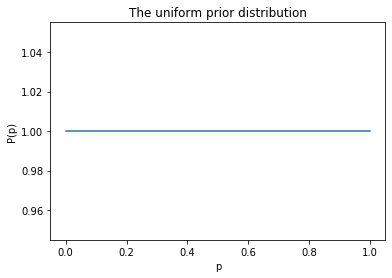

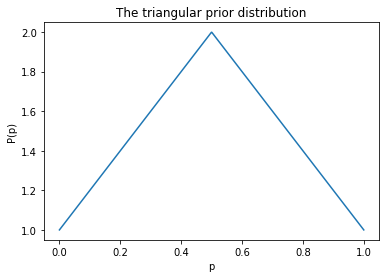

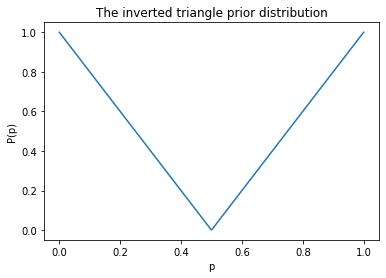

In [16]:
# visualise our priors

for key in priors_dict.keys():
    plt.plot(p_array, priors_dict[key](p_array))
    plt.xlabel('p')
    plt.ylabel('P(p)')
    plt.title('The %s prior distribution' % key)
    plt.show()

For each prior, we need to know the probability of the evidence, by integrating over the possible values of $p$:
$$P(x)=\int_0^1 P(x|p)P(p)\;\mathrm{d}p.$$

We will use the binomial likelihood, since we have shown that the negative binomial likelihood will give the same posterior for any prior, since bayesian inference satisfies the likelihood principle.

In [17]:
# compute the probabilities of evidence under different priors

evidence_dict = {}

for key in priors_dict.keys():
    evidence_dict[key] = integrate(lambda p: priors_dict[key](p)*binom_likelihood(p), 0, 1)[0]

# note: the scipy integrate.quad function takes a callable object, an upper limit, and a lower limit, and
# returns a tuple consisting of an estimate of the integral and an upper bound on the error; we take just
# the estimate, and don't worry about the error for now; typically integrate.quad is a good integrator which
# has small errors

In [18]:
# display P(x) under each of our priors

evidence_dict

{'uniform': 0.0010515247108302632,
 'triangular': 0.002046316741321143,
 'inverted triangle': 5.673268033934231e-05}

Note that the evidence is quite unlikely under all three priors; this is to be expected, as we are looking just at the probability of getting the specific outcome of 450 heads out of 950 tosses. It is however important to note that for the inverted triangle prior, the evidence is much less likely than under the other two priors; this is because that prior deems values of $p$ close to 0.5 very improbable, and 450/950 is not far from 0.5.

Now we can compute our posterior probabilities, using Bayes' Theorem:
$$P(p|x)=\frac{P(x|p)P(p)}{P(x)}.$$

In [19]:
# for each prior, compute the corresponding posterior probability
# note that although the evidences calculated above depend on the particular likelihood function we use (binomial
# vs negative binomial), at this step the difference will cancel out, so the posterior is the same regardless

posteriors_dict = {}

for key in priors_dict.keys():
    
    posteriors_dict[key] = lambda p: binom_likelihood(p) * priors_dict[key](p) / evidence_dict[key]

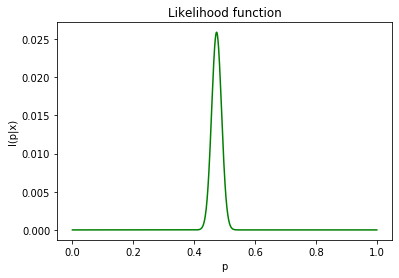

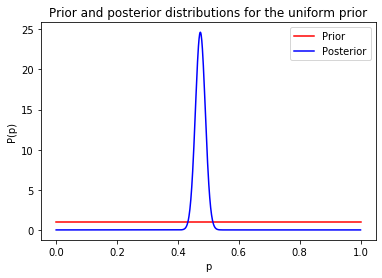

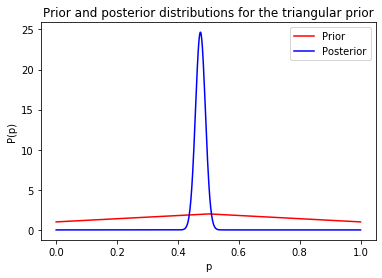

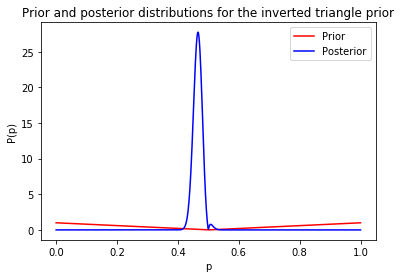

In [20]:
# visualise our posteriors

plt.plot(p_array, binom_likelihood(p_array), color='g')
plt.title("Likelihood function")
plt.xlabel('p')
plt.ylabel('l(p|x)')
plt.show()

for key in priors_dict.keys():
    plt.plot(p_array, priors_dict[key](p_array), color='r')
    plt.plot(p_array, posteriors_dict[key](p_array), color='b')
    plt.legend(['Prior', 'Posterior'])
    plt.xlabel('p')
    plt.ylabel('P(p)')
    plt.title('Prior and posterior distributions for the %s prior' % key)
    plt.show()

Observe how, for all three of our priors, the posterior distribution assigns a *much* higher probability to values of $p$ close to 450/950 than the prior does, and a lower probability for values far away from this. This even holds true for the inverted triangle prior, where the prior considers extreme biases more likely; even with this prior belief, the evidence is compelling that the coin has bias around 450/950.

Observe also how all three posterior distributions are very similar in shape to the likelihood function; this is because the large number of tosses means we have a significant amount of evidence, so the likelihood function has a very sharp peak, causing it to dominate any reasonable prior, so substantially different priors can end up giving similar outcomes. Compare with the hypothesis testing case, where a slight difference in our beliefs about the experimenter's intentions lead to a change in our outcomes.

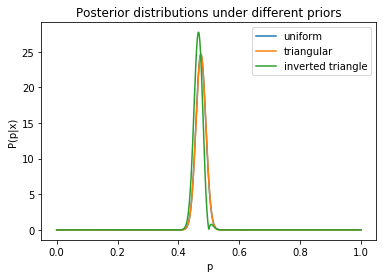

In [21]:
# plot all the posterior distributions on the same axes to compare them

legend = []

for key in posteriors_dict.keys():
    plt.plot(p_array, posteriors_dict[key](p_array))
    legend.append(key)

plt.xlabel('p')
plt.ylabel('P(p|x)')
plt.title('Posterior distributions under different priors')
plt.legend(legend)
plt.show()

Note that there is almost no difference between the posterior distributions. The uniform and triangular priors give essentially identical posteriors, while the inverted triangular prior gives a slightly different distribution, as it is based on a prior belief that $p$ is far from 0.5.

So even with quite different prior beliefs, a bayesian approach can lead us to the same posterior belief in light of the evidence. Contrast with hypothesis testing, where a slight difference in how the experiment was modelled could change the results! Of course, the actual p-values for the hypothesis tests were quite close - one was slightly above 0.05, the other slightly below - so it is not as though hypothesis testing really gave drastically different results in the two situations. But because hypothesis testing makes a sharp distinction based on an arbitrary boundary, even a small difference in values can lead to a complete difference in outcome. In the bayesian approach, however, small differences in input (and even big differences, with strong enough evidence!) tend to lead to small differences in output.

Crucially, the bayesian approach not only is relatively insensitive to small changes, but is totally insensitive to changes in things other than the actual data: it satisfies the likelihood principle, and so only the actual data presented matter for the inference. In hypothesis testing, on the other hand, irrelevant differences in experimental setup can change the p-value calculated, and the sharp cutoff at the significance level means that even a slight difference in the p-value can totally change the result of the inference. Hypothesis testing is less reliable and less objective than bayesian inference.